# Assignment 7

In [42]:
import sys
import os
import json
import pandas as pd
import numpy as np
import optparse
import matplotlib.pyplot as plt
import math
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, SimpleRNN, Bidirectional, CuDNNLSTM
from keras import Input
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow import keras

from collections import OrderedDict
import seaborn as sns

In [2]:
dataframe = pd.read_csv("../data/dev-access.csv", engine='python', quotechar='|', header=None)

In [3]:
dataframe.head()

,0,1
0,"{""timestamp"":1502738402847,""method"":""post"",""qu...",0
1,"{""timestamp"":1502738402849,""method"":""post"",""qu...",0
2,"{""timestamp"":1502738402852,""method"":""post"",""qu...",0
3,"{""timestamp"":1502738402852,""method"":""post"",""qu...",0
4,"{""timestamp"":1502738402853,""method"":""post"",""qu...",0


In [4]:
dataset = dataframe.values

In [5]:
dataset.shape

(26773, 2)

In [6]:
X = dataset[:,0]

In [7]:
Y = dataset[:,1]

In [8]:
for index, item in enumerate(X):
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

In [9]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

In [10]:
max_log_length = 1024
X_processed = pad_sequences(X, maxlen=max_log_length)

In [11]:
X_processed = np.asarray(X_processed).astype(np.float32)
Y = np.asarray(Y).astype(np.float32)

In [12]:
X_processed

array([[ 0.,  0.,  0., ...,  1., 19., 19.],
       [ 0.,  0.,  0., ...,  1., 19., 19.],
       [ 0.,  0.,  0., ...,  1., 19., 19.],
       ...,
       [ 0.,  0.,  0., ...,  1., 19., 19.],
       [ 0.,  0.,  0., ...,  1., 19., 19.],
       [ 0.,  0.,  0., ...,  1., 19., 19.]], dtype=float32)

In [13]:
tf_dataset = Dataset.from_tensor_slices((X_processed,Y))
tf_dataset = tf_dataset.shuffle(buffer_size=len(X_processed))
tf_dataset = tf_dataset.batch(128)

In [14]:
DATASET_SIZE = len(tf_dataset)
train_size = int(0.75 * DATASET_SIZE)
val_size = int(0.75 * train_size)

train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)
val_dataset = train_dataset.skip(val_size)
train_dataset = train_dataset.take(val_size)

In [15]:
len(test_dataset)

53

In [16]:
for feature_batch,label_batch in test_dataset.take(1):
    print("feature:",feature_batch) 
    print("label:",label_batch)

feature: tf.Tensor(
[[ 0.  0.  0. ... 12. 12. 19.]
 [ 0.  0.  0. ...  1. 19. 19.]
 [ 0.  0.  0. ... 12. 12. 19.]
 ...
 [ 0.  0.  0. ...  1. 19. 19.]
 [ 0.  0.  0. ... 12. 12. 19.]
 [ 0.  0.  0. ... 12. 12. 19.]], shape=(128, 1024), dtype=float32)
label: tf.Tensor(
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0.], shape=(128,), dtype=float32)


In [17]:
def simple_RNN_model(embedding_input,embedding_output,embedding_input_length):
    inputs = Input(shape=(None,), dtype="float32")
    x = Embedding(embedding_input, embedding_output,input_length=embedding_input_length)(inputs)
    x = SimpleRNN(units=32,activation='relu')(x)
    predictions = Dense(1, activation="relu", name="predictions")(x)
    model = keras.Model(inputs, predictions)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"],run_eagerly=True)
    return model

In [18]:
simple_rnn = simple_RNN_model(num_words,32,max_log_length)

In [19]:
simple_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          2016      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
simple_rnn.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[callback,model_checkpoint])

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.79863, saving model to best_model.h5
117/117 [==============================] - 206s 2s/step - loss: 0.8174 - accuracy: 0.5714 - val_loss: 0.4798 - val_accuracy: 0.7986
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6293
Epoch 2: val_accuracy did not improve from 0.79863
117/117 [==============================] - 211s 2s/step - loss: 0.6659 - accuracy: 0.6293 - val_loss: 0.6039 - val_accuracy: 0.6314
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.6252
Epoch 3: val_accuracy did not improve from 0.79863
117/117 [==============================] - 205s 2s/step - loss: 0.6016 - accuracy: 0.6252 - val_loss: 0.5974 - val_accuracy: 0.6234
Epoch 4/10
117/117 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.6301
Epoch 4: val_accuracy did not impro

In [21]:
simple_rnn = load_model("best_model.h5")
simple_rnn.evaluate(test_dataset)

53/53 [==============================] - 5s 86ms/step - loss: 0.4826 - accuracy: 0.8020


[0.4825523793697357, 0.8020069003105164]

In [88]:
def simple_LSTM_model(embedding_input,embedding_output,embedding_input_length):
    inputs = Input(shape=(None,), dtype="float32")
    x = Embedding(embedding_input, embedding_output,input_length=embedding_input_length)(inputs)
    x = LSTM(units=64,recurrent_dropout=0.5)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation="relu", name="predictions")(x)
    model = keras.Model(inputs, predictions)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"],run_eagerly=True)
    return model

In [89]:
simple_lstm = simple_LSTM_model(num_words,32,max_log_length)
simple_lstm.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 32)          2016      
                                                                 
 lstm_19 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [90]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
simple_lstm.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[callback,model_checkpoint])

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.5432
Epoch 1: val_accuracy improved from -inf to 0.63672, saving model to best_model_lstm.h5
117/117 [==============================] - 1134s 10s/step - loss: 0.8133 - accuracy: 0.5432 - val_loss: 0.6116 - val_accuracy: 0.6367
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.6601
Epoch 2: val_accuracy improved from 0.63672 to 0.84961, saving model to best_model_lstm.h5
117/117 [==============================] - 1116s 10s/step - loss: 0.6565 - accuracy: 0.6601 - val_loss: 0.7302 - val_accuracy: 0.8496
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7208
Epoch 3: val_accuracy improved from 0.84961 to 0.85430, saving model to best_model_lstm.h5
117/117 [==============================] - 1155s 10s/step - loss: 0.6790 - accuracy: 0.7208 - val_loss: 0.5902 - val_accuracy: 0.8543
Epoch 4/10
117/117 [====================

In [91]:
simple_lstm = load_model("best_model_lstm.h5")
simple_lstm.evaluate(test_dataset)

53/53 [==============================] - 18s 331ms/step - loss: 0.7055 - accuracy: 0.8827


[0.7055243849754333, 0.8827317953109741]

In [22]:
def complex_RNN_model(embedding_input,embedding_output,embedding_input_length):
    inputs = Input(shape=(None,), dtype="float32")
    x = Embedding(embedding_input, embedding_output,input_length=embedding_input_length)(inputs)
    x = CuDNNLSTM(units=64,return_sequences=True,go_backwards=True)(x)
    x = Dropout(0.5)(x)
    x = CuDNNLSTM(32,go_backwards=True)(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation="relu", name="predictions")(x)
    model = keras.Model(inputs, predictions,)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy",tf.keras.metrics.Precision()],run_eagerly=True)
    return model

Using precision as a metric as we are predicting whether the dev access is authorized, and a more precise model will be better suited to pick out bad actors.

In [23]:
complex_rnn = complex_RNN_model(num_words,32,max_log_length)
complex_rnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 32)          2016      
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, None, 64)          25088     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 32)                12544     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_complex.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
precision_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_complex_precision.h5', monitor='val_precision', mode='max', verbose=1, save_best_only=True)
complex_rnn.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[callback,model_checkpoint,precision_checkpoint])

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.5835 - precision: 0.6499
Epoch 1: val_accuracy improved from -inf to 0.67051, saving model to best_model_complex.h5

Epoch 1: val_precision improved from -inf to 0.97764, saving model to best_model_complex_precision.h5
117/117 [==============================] - 25s 190ms/step - loss: 0.7745 - accuracy: 0.5835 - precision: 0.6499 - val_loss: 0.5288 - val_accuracy: 0.6705 - val_precision: 0.9776
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7461 - precision: 0.8800
Epoch 2: val_accuracy improved from 0.67051 to 0.96719, saving model to best_model_complex.h5

Epoch 2: val_precision improved from 0.97764 to 0.99421, saving model to best_model_complex_precision.h5
117/117 [==============================] - 22s 186ms/step - loss: 0.5862 - accuracy: 0.7461 - precision: 0.8800 - val_loss: 0.1479 - val_accuracy: 0.9672 - val_precision: 0.9942
Epoch 3/10
117/117

In [25]:
complex_rnn = load_model("best_model_complex.h5")
complex_rnn.evaluate(test_dataset)

53/53 [==============================] - 3s 55ms/step - loss: 0.1447 - accuracy: 0.9876 - precision: 0.9955


[0.14473551511764526, 0.987569272518158, 0.9954614043235779]

## Conceptual Questions

#### 5) Explain the difference between the relu activation function and the sigmoid activation function.

The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It can be represented as $$ A = \begin{cases}
f(x) & \text{ if } x>0 \\ 
0 & \text{ if } x<=0
\end{cases}$$
It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

The sigmoid function is a special form of the logistic function and is usually denoted by $σ(x)$ or $sig(x)$. It is given by:
$$ \sigma (x) = \frac{1}{1+e^{-x}}$$
It ranges between 0 to 1 and is used for predictions as it always ranges between 0 to 1. The function is monotonically increasing. The function is continuous everywhere. The function is differentiable everywhere in its domain. Numerically, it is enough to compute this function’s value over a small range of numbers, e.g., [-10, +10]. For values less than -10, the function’s value is almost zero. For values greater than 10, the function’s values are almost one.

A general problem with both the sigmoid and tanh functions is that they saturate. This means that large values snap to 1.0 and small values snap to -1 or 0 for tanh and sigmoid respectively. Further, the functions are only really sensitive to changes around their mid-point of their input, such as 0.5 for sigmoid and 0.0 for tanh.
The limited sensitivity and saturation of the function happen regardless of whether the summed activation from the node provided as input contains useful information or not. Once saturated, it becomes challenging for the learning algorithm to continue to adapt the weights to improve the performance of the mode.
Layers deep in large networks using these nonlinear activation functions fail to receive useful gradient information. Error is back propagated through the network and used to update the weights. The amount of error decreases dramatically with each additional layer through which it is propagated, given the derivative of the chosen activation function. This is called the vanishing gradient problem and prevents deep (multi-layered) networks from learning effectively.

##### Advantages of the ReLu function:
    1. Computational Simplicity: The ReLu function cant be implemented using only a max() function call.
    2. Representational Sparsity: As it outputs a true zero, snapping does not occur.
    3. Linear Behaviour: In general, a neural network is easier to optimize when its behavior is linear or close to linear.  

#### 6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).

An epoch is when all the training data is used at once and is defined as the total number of iterations of all the training data in one cycle for training the machine learning model. Another way to define an epoch is the number of passes a training dataset takes around an algorithm. One pass is counted when the data set has done both forward and backward passes. An epoch is made up of one or more batches, where we use a part of the dataset to train the neural network. We call passing through the training examples in a batch an iteration.
Lets look at an example: Consider a dataset that has 200 samples. These samples take 1000 epochs or 1000 turns for the dataset to pass through the model. It has a batch size of 5. This means that the model weights are updated when each of the 40 batches containing five samples passes through. Hence the model will be updated 40 times.

#### 7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
Unless specified a dropout layer will not be used on test data sets, only on training.

#### 8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?

RNN's/LSTM work on the principle where connections between nodes can create a cycle, allowing output from some nodes to affect subsequent input to the same nodes. This allows it to exhibit temporal dynamic behavior. When working with string content, the location of a string and its surrounding words are important to its location in the string. RNN's because of their temporal behaviour, acknowledges the locations, and factors that in its predictions. A CNN on the other hand is space invariant. As it does not consider, the location of an object to be important ( It works on identifying an object irrespective of it's location) it fails to consider the most important aspects of language. That is why an RNN/LSTM is better than a CNN.

#### 9) Explain what RNN problem is solved using LSTM and briefly describe how.

The biggest problem solved by RNN's/LSTM is dynamic temporal behaviour, i.e it is able to factor the location/time of an object, and it accomplishes this by allowing the weights of previous objects to affect the weights of future objects. RNNs achieve a memory through a feedback loop in the cell. And this is the main difference between a RNN and a traditional neural network. The feed-back loop allows information to be passed within a layer in contrast to feed-forward neural networks in which information is only passed between layers.

## PART B: Time Series with LSTMs

In [26]:
time_series_data = pd.read_csv("../data/DAYTON_hourly.csv") 
time_series_data.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [27]:
time_series_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [28]:
time_series_data['Datetime'] = pd.to_datetime(time_series_data['Datetime'])
time_series_data.sort_values(by="Datetime", inplace=True)

In [29]:
time_series_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121275 entries, 2183 to 116163
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 MB


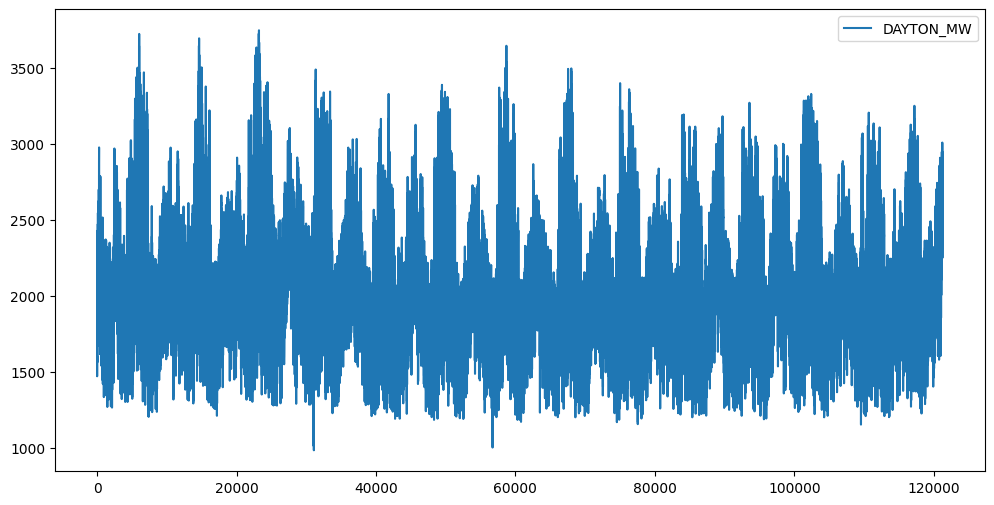

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
time_plot = sns.lineplot(data=time_series_data,ax=ax)

In [34]:
from typing import Tuple


def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test

In [71]:
lag = 3
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(
    time_series_data, time_series_data.columns[-1], lag, test_ratio
)

In [62]:
def time_series_lstm(lag):
    #calculate number of units for window sequence:
    n_units = 0
    for i in range(0,10):
        powered_value = pow(2,i)
        if (powered_value>lag) & (powered_value>50):
            n_units = pow(2,i)
            break
    inputs = Input(shape=(lag,1), dtype="float32")
    x = LSTM(n_units, activation='relu')(inputs)
    predictions = Dense(1,name="predictions", activation='relu')(x)
    model = keras.Model(inputs, predictions,)
    model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly=True)
    return model

Choosing the Number of Units in an LSTMshould always be based off of the sequence lenght. We should also consider to not use more units that necessary, as you could run into the vanishing gradent problem. Hence why you look for the closes power of 2, while being the closest power to the lag and to 50(baseline). 

In [63]:
time_series_lstm_model = time_series_lstm(lag)
print(time_series_lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_time_series_3.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
time_series_lstm_model.fit(X_train,Y_train,validation_split=0.25,epochs=10,callbacks=[callback,model_checkpoint])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3, 1)]            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                16896     
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2415/2416 [============================>.] - ETA: 0s - loss: 61586.3398 - rmse: 248.1660
Epoch 1: val_rmse improved from inf to 96.12857, saving model to best_model_time_series_3.h5
2416/2416 [==============================] - 67s 28ms/step - loss: 61566.8242 - rmse: 248.1266 - val_loss: 9240.7031 - v

In [72]:
time_series_lstm_model = load_model("best_model_time_series_3.h5")
preds = time_series_lstm_model.predict(X_test)
result_3 = time_series_lstm_model.evaluate(X_test,Y_test)

569/569 [==============================] - 1s 2ms/step - loss: 2072.7620 - rmse: 45.5276


In [65]:
lag = 24
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(
    time_series_data, time_series_data.columns[-1], lag, test_ratio
)

In [66]:

time_series_lstm_model_24 = time_series_lstm(lag)
print(time_series_lstm_model_24.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_time_series_24.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
time_series_lstm_model_24.fit(X_train,Y_train,validation_split=0.25,epochs=10,callbacks=[callback,model_checkpoint])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                16896     
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2416/2416 [==============================] - ETA: 0s - loss: 162150.0625 - rmse: 402.6786
Epoch 1: val_rmse improved from inf to 210.91420, saving model to best_model_time_series_24.h5
2416/2416 [==============================] - 228s 95ms/step - loss: 162150.0625 - rmse: 402.6786 - val_loss: 44484.80

In [67]:
time_series_lstm_model_24 = load_model("best_model_time_series_24.h5")
result_24 = time_series_lstm_model_24.evaluate(X_test,Y_test)
preds_24 = time_series_lstm_model_24.predict(X_test)

569/569 [==============================] - 3s 5ms/step


In [68]:
lag = 24
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(
    time_series_data, time_series_data.columns[-1], lag, test_ratio
)

In [69]:
def bidirectional_time_series_lstm(lag):
    #calculate number of units for window sequence:
    n_units = 0
    for i in range(0,10):
        powered_value = pow(2,i)
        if (powered_value>lag) & (powered_value>50):
            n_units = pow(2,i)
            break
    inputs = Input(shape=(lag,1), dtype="float32")
    x = Bidirectional(LSTM(n_units, activation='relu'))(inputs)
    predictions = Dense(1, name="predictions")(x)
    model = keras.Model(inputs, predictions,)
    model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly=True)
    return model
time_series_lstm_model_bi = bidirectional_time_series_lstm(lag)
print(time_series_lstm_model_bi.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_time_series_bi.h5', monitor='val_rmse', mode='min', verbose=1, save_best_only=True)
time_series_lstm_model_bi.fit(X_train,Y_train,validation_split=0.25,epochs=10,callbacks=[callback,model_checkpoint])

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2416/2416 [==============================] - ETA: 0s - loss: 82119.4531 - rmse: 286.5649
Epoch 1: val_rmse improved from inf to 188.08263, saving model to best_model_time_series_bi.h5
2416/2416 [==============================] - 425s 17

In [70]:
time_series_lstm_model_bi = load_model("best_model_time_series_bi.h5")
result_bi = time_series_lstm_model_bi.evaluate(X_test,Y_test)
preds_bi = time_series_lstm_model_bi.predict(X_test)


569/569 [==============================] - 5s 9ms/step


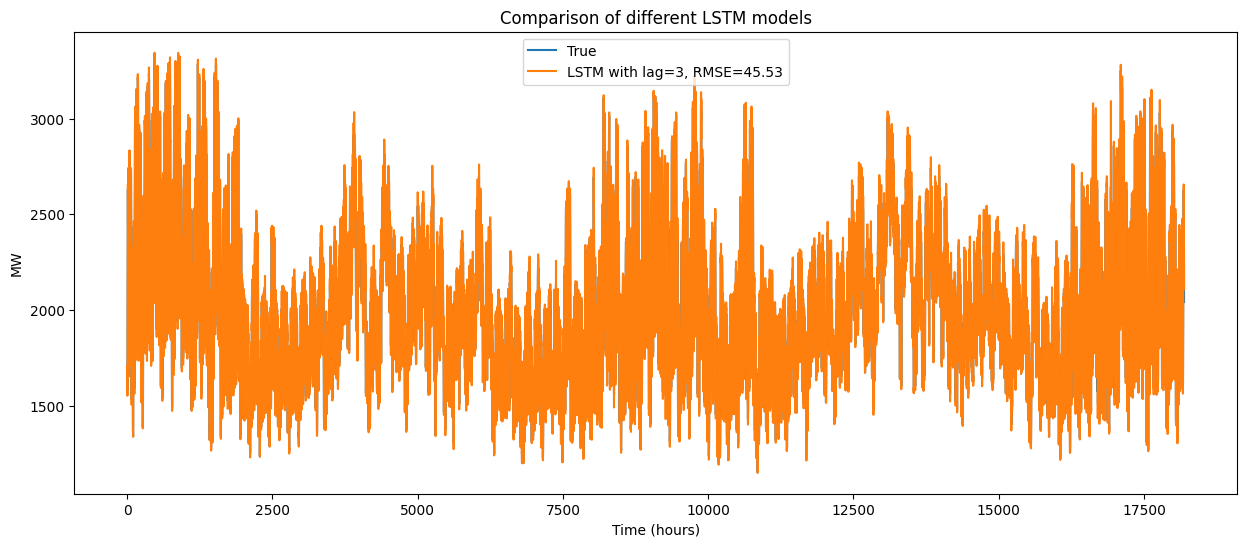

In [74]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label="True")
plt.plot(preds, label="LSTM with lag=3, RMSE={:.2f}".format(result_3[1]))
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("MW")
plt.title("Comparison of different LSTM models")
plt.show()

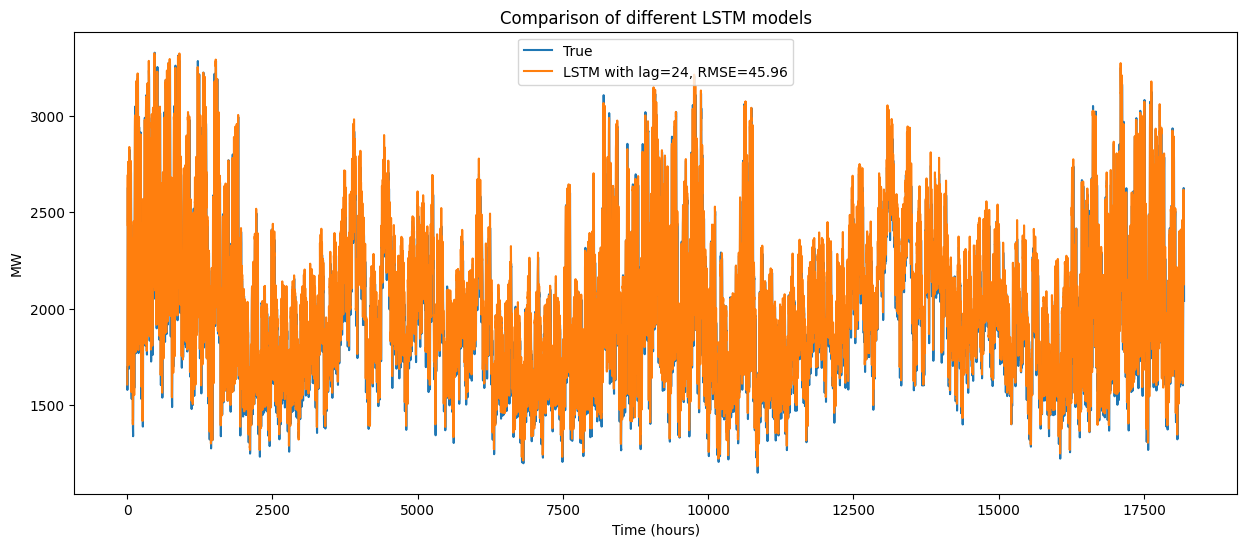

In [75]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label="True")
plt.plot(preds_24, label="LSTM with lag=24, RMSE={:.2f}".format(result_24[1]))
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("MW")
plt.title("Comparison of different LSTM models")
plt.show()

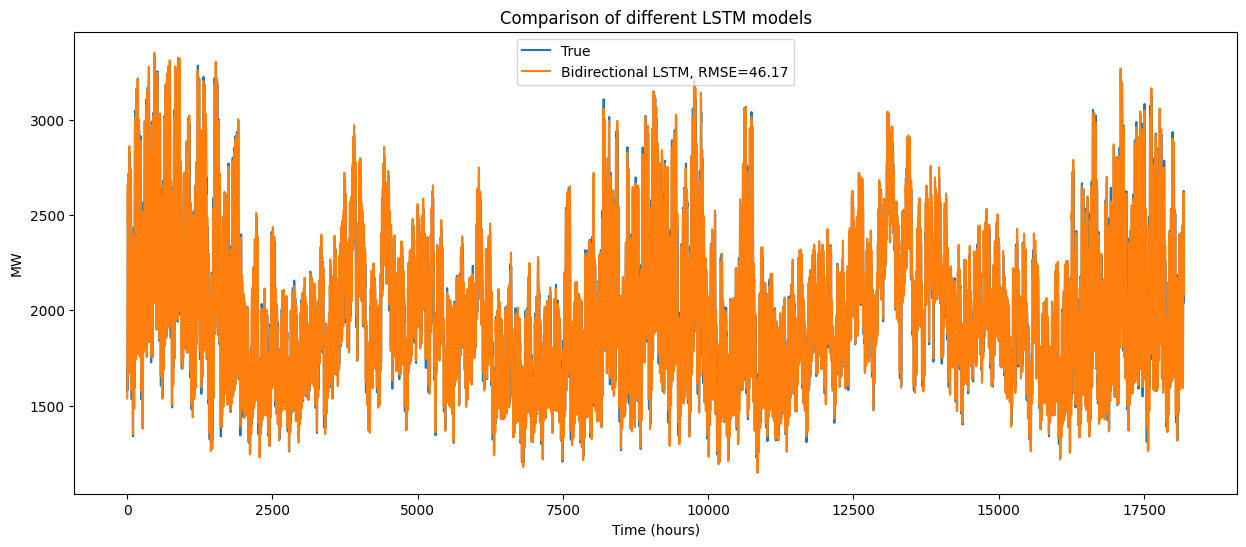

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label="True")
plt.plot(preds_bi, label="Bidirectional LSTM, RMSE={:.2f}".format(result_bi[1]))
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("MW")
plt.title("Comparison of different LSTM models")
plt.show()

In [81]:
print(max(time_series_data['DAYTON_MW']))
print(min(time_series_data['DAYTON_MW']))

3746.0
982.0


### Conclusions:

Looking at the max and the min values, and considering that the NN has an RMSE of around 45,46, we can estimate the predictions are decently accurate and that the model is predicting the values well.